<a href="https://colab.research.google.com/github/vocaltrainer/pipeline_woo/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 사전훈련된 신경망 써보기

##resnet으로 이미지분류 해보기

In [ ]:
from torchvision import models
resnet = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 195MB/s]


In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], #사전에 모든 훈련데이터에 대한 평균
            std=[0.229, 0.224, 0.225]
        )])

In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/파딥마 자료/세탁기.jpg")

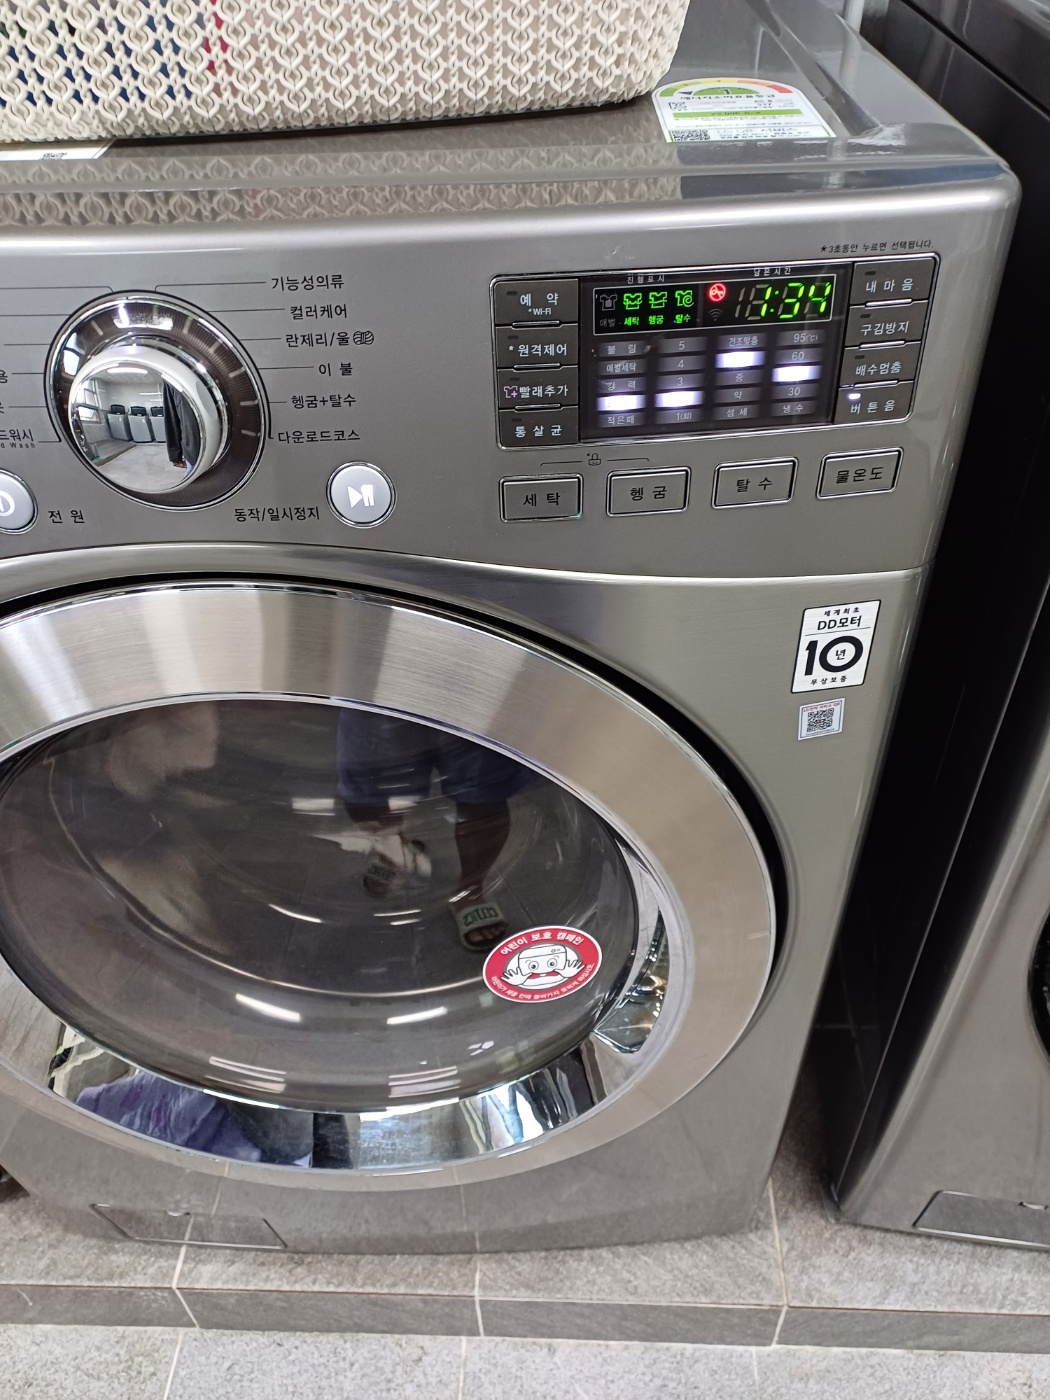

In [ ]:
img

In [ ]:
img_t = preprocess(img)

In [ ]:
import torch
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
out = resnet(batch_t)

In [ ]:
with open('/content/drive/MyDrive/파딥마 자료/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [ ]:
_, index = torch.max(out, 1)


In [ ]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('washer, automatic washer, washing machine', 99.70709228515625)

In [ ]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('washer, automatic washer, washing machine', 99.70709228515625),
 ('microwave, microwave oven', 0.04600797966122627),
 ('loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
  0.036093827337026596),
 ('CD player', 0.03311821073293686),
 ('dishwasher, dish washer, dishwashing machine', 0.02658759243786335)]

##Cyclegan으로 이미지생성하기

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3>

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
netG = ResNetGenerator()

In [ ]:
model_path = '/content/drive/MyDrive/파딥마 자료/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)  #사전 훈련된 파라미터들
netG.load_state_dict(model_data)     #사전 훈련된 파라미터 적용

<All keys matched successfully>

In [ ]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [ ]:
from PIL import Image
from torchvision import transforms

In [ ]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

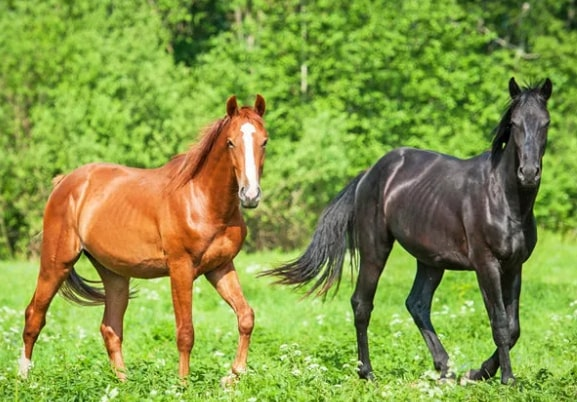

In [ ]:
img = Image.open("/content/drive/MyDrive/파딥마 자료/말.jpg")
img

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
batch_out = netG(batch_t)

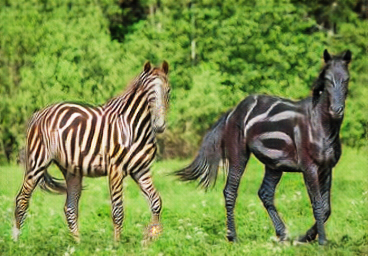

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('../data/p1ch2/zebra.jpg')
out_img

##토치허브에서 모델 다운받기

In [ ]:
import torch
from torch import hub

In [ ]:
resnet18_model = hub.load('pytorch/vision:master',  #깃헙 저장소 이름과 브랜치
                          'resnet18',               #함수 이름
                          pretrained=True)          #사전훈련된 파라미터 사용여부

#2. 텐서에 대해

실제 저장소는 torch.Storage이며 숫자 데이터를 가진 1차원 배열이다.

 텐서는 이에 대한 뷰를 만든다.

#3. 데이터를 텐서로 변환

##이미지

In [ ]:
import imageio
import torch

#이미지를 (H,W,C)형태의 넘파이 객체로 변환
img_arr = imageio.imread('/content/drive/MyDrive/파딥마 자료/세탁기.jpg')
img_arr.shape

<ipython-input-5-d9ea31e57ac6>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread('/content/drive/MyDrive/파딥마 자료/세탁기.jpg')


(1400, 1050, 3)

In [ ]:
img = torch.from_numpy(img_arr)  #넘파이배열로 텐서생성, 메모리상에서 둘이 동일한 위치 참조
out = img.permute(2, 0, 1)       #텐서는 (C,H,W)의 형태이므로 배열순서 변경

In [ ]:
batch_size = 3
#미리 적당한 공간을 할당해 작업을 좀더 효율적으로 하기위함
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

In [ ]:
import os

data_dir = '/content/drive/MyDrive/파딥마 자료/image-cats'

#여러 이미지를 텐서로 변환 후 배치에 저장
filenames = [name for name in os.listdir(data_dir)
             if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # <1>
    batch[i] = img_t     #batch 텐서: (N,C,H,W)

<ipython-input-8-fba0e8d5332f>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(os.path.join(data_dir, filename))


In [ ]:
#평균, 표준편차로 데이터 정규화
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

##3차원 이미지

In [ ]:
#용적 이미지 텐서 : (N,C,D,H,W)

import imageio
import torch

dir_path = "/content/drive/MyDrive/파딥마 자료/의료용 디지털 영상"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape  #99개의 2차원 dcm이미지를 하나의 3D볼륨으로 읽어옴(넘파이)
               #(D,H,W)형태

Reading DICOM (examining files): 1/99 files (1.0%)45/99 files (45.5%)87/99 files (87.9%)99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 30/99  (30.3%)56/99  (56.6%)87/99  (87.9%)99/99  (100.0%)


(99, 512, 512)

In [ ]:
#파이토치는 (C,D,H,W)형태를 원하므로 C차원 추가
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)  #vol 0번째 차원에 크기1인 차원 추가

vol.shape

torch.Size([1, 99, 512, 512])

##csv

In [ ]:
import pandas as pd

a = pd.read_csv("/content/drive/MyDrive/파딥마 자료/winequality-white.csv",delimiter=';')
a.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [ ]:
import pandas as pd
import numpy as np
import torch
wine = np.loadtxt(
    "/content/drive/MyDrive/파딥마 자료/winequality-white.csv",
    dtype=np.float32,
    delimiter=";",
    skiprows=1)
wine

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [ ]:
wineq = torch.tensor(wine, dtype=torch.float32)

In [ ]:
wineq.shape, wineq.stride()

(torch.Size([4898, 12]), (12, 1))

In [ ]:
data = wineq[:,:-1]
target = wineq[:,-1]
target

tensor([6., 6., 6.,  ..., 6., 7., 6.])

1.target열 값들의 숫자비교가 의미가 있다면, 정수벡터로 처리

In [ ]:
target = wineq[:,-1].long()

2.target열 값들의 숫자비교가 의미가 없고 그저 라벨링일때, 원핫인코딩

##시계열 데이터(미완)

In [ ]:
import pandas as pd

a = pd.read_csv("/content/drive/MyDrive/파딥마 자료/hour-fixed.csv",delimiter=',')
a.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


판다스보다 넘파이가 좋은것 같음

In [ ]:
import numpy as np
import torch

bikes_numpy = np.loadtxt(
    "/content/drive/MyDrive/파딥마 자료/hour-fixed.csv",
    dtype=np.float32,
    delimiter=",",
    skiprows=1,
    converters={1: lambda x: float(x[8:10])}) # <1>
bikes = torch.from_numpy(bikes_numpy)
bikes


tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

In [ ]:
bikes.shape, bikes.stride()  #17520시간에 17개열

(torch.Size([17520, 17]), (17, 1))

In [ ]:
#차원 추가 : 17520시간을 24시간으로 쪼개서 day 차원 추가
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

In [ ]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

##텍스트(미완)

#4. 학습기법

1. lr 조절
2. 각 파라미터의 입력을 정규화시켜준다.(각 파라미터별로 lr을 따로 설정할 수 없으니)
3.데이터를 한번 그려봐라
4.파이토치 자동미분
5. 옵티마이저 설정
6.validation

##파이토치 자동미분(경사하강법)

In [ ]:
import torch
#라벨
t_c = [0.5,14.0,15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]
t_c = torch.tensor(t_c)
#train
t_u = [35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]
t_u = torch.tensor(t_u)

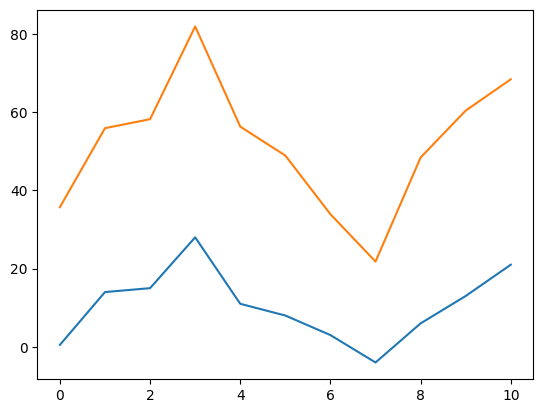

In [ ]:
#시각화
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(t_c)
plt.plot(t_u)
plt.show()

In [ ]:
#파라미터 초기값
import torch
params = torch.tensor([1.0,0.0],requires_grad=True)
#중요!!!!!!!!!!!!!requires_grad : params를 조상으로 두는 모든 텐서는 자동미분및 params의 접근 가능

In [ ]:
#선형함수, 손실함수
def model(t_u,w,b):
  return t_u*w+b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
#자동 미분
loss = loss_fn(model(t_u, *params), t_c) #loss는 params를 조상으로 둠

if params.grad is not None:              #backward() 전에 실행되어야 함.
  params.grad.zero_()                    #params.grad는 누적이므로 계속해서 0으로 초기화시켜줘야함

loss.backward()                          #즉, backward() : params.grad에 새로운 기울기 누적o(저장x) 가능

params.grad                              #기울기 계산

tensor([4517.2969,   82.6000])

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        #일반적인 경사하강법. 옵티마이저 부분에선 새로운 방법 제시
        with torch.no_grad():  # requires_grad = False
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [ ]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_u*0.1, #입력값 정규화
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

##옵티마이저

옵티마이저 객체 : 파라미터 리스트를 생성자 인자로 가짐

zero_grad(): 파라미터의 모든 grad를 0으로 만듦

step() : 옵티마이저별로 구현된 전략에 따라 파라미터 조정

###사용방법(SGD로 예시를 둠)

In [ ]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()  #중요!, backward()위에 위치해야함
        loss.backward()
        optimizer.step()  #params.grad를 수정

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [ ]:
import torch
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = torch.optim.Adam([params], lr=learning_rate) #옵티마이저 객체 생성

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 25.590321
Epoch 1000, Loss 22.958574
Epoch 1500, Loss 19.641720
Epoch 2000, Loss 16.026117
Epoch 2500, Loss 12.481897
Epoch 3000, Loss 9.332447
Epoch 3500, Loss 6.805122
Epoch 4000, Loss 4.996394
Epoch 4500, Loss 3.867487
Epoch 5000, Loss 3.274242


tensor([  0.5017, -15.3177], requires_grad=True)

#5. 신경망 사용

forward대신 '__call__' 사용

(forward를 하면 제대로 수행되지 않을 코드들이 있을 수 있음.)

In [ ]:
import torch.nn as nn
import torch
from collections import OrderedDict

namedseq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 12)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(12 , 1))
]))

namedseq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=12, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=12, out_features=1, bias=True)
)

In [ ]:
for name, param in namedseq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([12, 1])
hidden_linear.bias torch.Size([12])
output_linear.weight torch.Size([1, 12])
output_linear.bias torch.Size([1])


In [ ]:
namedseq_model.weight

Parameter containing:
tensor([[0.0626]], requires_grad=True)

In [ ]:
namedseq_model.bias

Parameter containing:
tensor([0.6659], requires_grad=True)